In [1]:
from hipecta.data import ctaTelescope2Matrix
from hipecta import core
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, ConcatDataset, sampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import hipecta.plots as plots
from torchvision import transforms, utils
import math
import time
import os
import sys

converter_path = os.path.abspath(os.path.join('/home/jacquemont/GammaLearn/converter_hdf5'))
if converter_path not in sys.path:
    sys.path.append(converter_path)
    
from converter_hdf5 import *
from datasets import *

In [17]:
class CNNModelLSTEnergy2(nn.Module):
    def __init__(self):
        super(CNNModelLSTEnergy2, self).__init__()
        # in 55x55
        # conv1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu1 = nn.ReLU()
        # maxpooling 1, by default floor
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        # size = 27x27*16
        # conv2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu2 = nn.ReLU()
        # maxpooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        # batch norm
        self.batchnorm2 = nn.BatchNorm2d(32)
        #size = 13x13*32
        # conv3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu3 = nn.ReLU()
        # maxpooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2) # nn.AvgPool2d
        # batch norm
        self.batchnorm3 = nn.BatchNorm2d(64)
        # size = 6x6*64
        # conv4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # non-linearity
        self.relu4 = nn.ReLU()    
        # size = 3x3*128
        # readout, regression of energy
        self.fc1 = nn.Linear(128*6*6, 256)
        
        self.fc2 = nn.Linear(256, 64)
        
        self.fc3 = nn.Linear(64, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.batchnorm1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.batchnorm2(out)
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        out = self.batchnorm3(out)
        out = self.conv4(out)
        out = self.relu4(out)

        # Reshape out from batch_size,128,6,6 to batch_size,128*6*6
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [3]:
test_file = '/home/jacquemont/projets_CTA/gamma0.hdf5'
f = h5py.File(test_file, 'r')
injTable = np.array(f['/Cameras/LSTCAM/injTable'])
nbRow = f['/Cameras/LSTCAM'].attrs['nbRow']
nbCol = f['/Cameras/LSTCAM'].attrs['nbCol']
test_dataset = LSTCamDataset(hdf5_file=f,
                             transform=transforms.Compose([
                                 TelescopeToSquareMatrix(injTable, nbRow, nbCol),
                                 ToTensor()
                             ]))

test_dataset_2 = LSTCamDataset(hdf5_file=f)

test_dataset_3 = ConcatDataset([test_dataset, test_dataset_2])


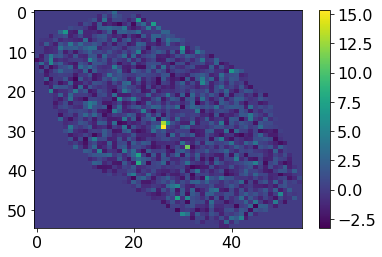

In [4]:
sample = test_dataset[4833]
plots.plotmatrix(sample['image'][0].numpy())

In [5]:
# Creation of subset train and test
random_indices = torch.randperm(len(test_dataset))
train_max_index = int(len(test_dataset)*0.9)
train_set_sampler = sampler.SubsetRandomSampler(random_indices[0:train_max_index])
test_set_sampler = sampler.SubsetRandomSampler(random_indices[train_max_index + 1:])

batch_size = 16
n_iters = 12000
num_epochs = int(n_iters/(len(test_dataset)*0.9/batch_size))
print(num_epochs)

# iterable subset creation
train_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           sampler=train_set_sampler)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          sampler=test_set_sampler)

21


In [6]:
if torch.cuda.is_available():
    print("CUDA available")

CUDA available


In [18]:
model = CNNModelLSTEnergy2()
model.double()
onGPU = True

## Run on GPU ##
if torch.cuda.is_available() and onGPU:
    print('model on GPU')
    model.cuda()

criterion = nn.MSELoss()

learning_rate = 0.00005

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
loss_epoch = []
itera = 0
time_1 = time.time()
gpu_time = 0
for epoch in range(num_epochs):
    
    for i, samples in enumerate(train_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])
        
        time_g = time.time()
        # clear gradient wrt parameters
        optimizer.zero_grad()
    
        # forward pass
        outputs = model(images)
    
        # claculate loss
        loss = criterion(outputs, labels[:, 0])
    
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        
    
        gpu_time += (time.time() - time_g)
        
        itera +=1
    
        if itera%100==0:    
            print('Epoch {} Iteration {} Training Loss {} '.format(epoch, itera, loss.data[0]))
            #print(model.state_dict()['conv1.weight'][0])
    time_g = time.time()
    energy = np.empty((0, 1), np.double)
    energy_inferred = np.empty((0, 1), np.double)
    for i, samples in enumerate(test_loader):

        ## Run on GPU ##
        if torch.cuda.is_available() and onGPU:
            #Load data as variable
            images = Variable(samples['image'].cuda())
            labels = Variable(samples['labels'].cuda())
        else:
            images = Variable(samples['image'])
            labels = Variable(samples['labels'])

        # forward pass
        outputs = model(images)
        energy = np.append(energy, labels.data[:,0].cpu().numpy())
        energy_inferred = np.append(energy_inferred, outputs.data[:,0].cpu().numpy())
    
    loss_epoch.append(np.mean((energy - energy_inferred)**2))
    gpu_time += (time.time() - time_g)
    print('Epoch {} Test Loss {} '.format(epoch, loss_epoch[epoch]))
    
ratio_gpu = gpu_time / (time.time() - time_1)
print('Ratio of gpu time : ', ratio_gpu)

model on GPU
Epoch 0 Iteration 100 Training Loss 1.3467215498665648 
Epoch 0 Iteration 200 Training Loss 0.5740444622886223 
Epoch 0 Iteration 300 Training Loss 0.18874118231499376 
Epoch 0 Iteration 400 Training Loss 0.32835349105720035 
Epoch 0 Iteration 500 Training Loss 0.6743483112230476 
Epoch 0 Test Loss 9.54668978836299 
Epoch 1 Iteration 600 Training Loss 0.38254213495341616 
Epoch 1 Iteration 700 Training Loss 1.0329480629507561 
Epoch 1 Iteration 800 Training Loss 0.29041114890060105 
Epoch 1 Iteration 900 Training Loss 4.115803914730671 
Epoch 1 Iteration 1000 Training Loss 0.38829779025256733 
Epoch 1 Iteration 1100 Training Loss 0.4793772064769072 
Epoch 1 Test Loss 8.98359412064098 
Epoch 2 Iteration 1200 Training Loss 0.7956622124301078 
Epoch 2 Iteration 1300 Training Loss 0.9790378797898835 
Epoch 2 Iteration 1400 Training Loss 6.1623917669386 
Epoch 2 Iteration 1500 Training Loss 63.94796460277533 
Epoch 2 Iteration 1600 Training Loss 2.253155050246312 
Epoch 2 Itera

In [19]:
model.eval()
energy = np.empty((0, 1), np.double)
energy_inferred = np.empty((0, 1), np.double)
for i, samples in enumerate(test_loader):

    ## Run on GPU ##
    if torch.cuda.is_available() and onGPU:
        #Load data as variable
        images = Variable(samples['image'].cuda())
        labels = Variable(samples['labels'].cuda())
    else:
        images = Variable(samples['image'])
        labels = Variable(samples['labels'])

   
    # forward pass
    outputs = model(images)

    energy = np.append(energy, labels.data[:,0].cpu().numpy())
    energy_inferred = np.append(energy_inferred, outputs.data[:,0].cpu().numpy())

In [20]:
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'loss_epoch': loss_epoch}, f='/home/jacquemont/MyDriveAtLap/saved_models/model2_energy_kaimin-uniform_batchnorm_lr0.00005_20epochs.tar')

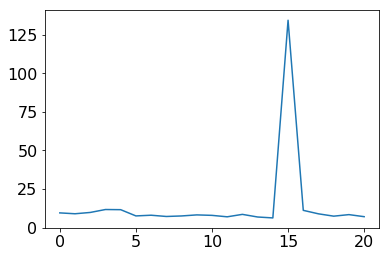

In [21]:
plt.plot(range(num_epochs), loss_epoch)
plt.show()

In [ ]:
loss_epoch

53.0754127502
68.2378473661


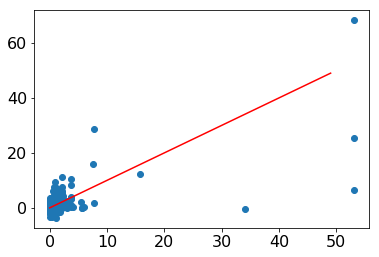

Test set mse :  6.30932306555


In [22]:
print(energy.max())
print(energy_inferred.max())
plt.scatter(energy, energy_inferred)
plt.plot(range(50),'r')
plt.show()
mse = np.mean((energy - energy_inferred)**2)
print('Test set mse : ', mse)


In [ ]:
f.close()